In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_lib import *


In [2]:
# Configuration parameters
FETCH_DATA = True  # Set to True to fetch new news data
FROM, TO = "2024-01-01", "2025-12-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "FTSE 100"
WINDOW = 7

In [3]:
keywords = [
    "FTSE 100",
    "inflation",
    "interest rates",
    "tariffs"
]

KEYWORDS = " OR ".join([f'"{keyword}"' for keyword in keywords])

In [4]:
import pandas as pd, time, random
from pygooglenews import GoogleNews

# Fetch news data function
def fetch_ftse_news_data():
    gn = GoogleNews(lang="en", country="GB")

    all_frames = []

    start_dt = pd.to_datetime(FROM)
    end_dt   = pd.to_datetime(TO)

    while start_dt <= end_dt:
        stop_dt = min(start_dt + pd.Timedelta(days=WINDOW-1), end_dt)

        feed    = gn.search(KEYWORDS,
                            from_=start_dt.strftime("%Y-%m-%d"),
                            to_  =stop_dt.strftime("%Y-%m-%d"))

        df      = pd.DataFrame(
                    {"date":  [pd.to_datetime(e.published).tz_localize(None)
                                for e in feed["entries"]],
                    "title": [e.title for e in feed["entries"]]}
                )
        all_frames.append(df)

        # polite pause to avoid 429 errors
        time.sleep(random.uniform(1.0, 2.5))
        start_dt = stop_dt + pd.Timedelta(days=1)

    news_df = (pd.concat(all_frames, ignore_index=True)
                .drop_duplicates())          # remove overlaps
    
    # Remove the "- name of the news source" suffix from titles
    news_df['title'] = news_df['title'].str.replace(r' - .+$', '', regex=True)
    

    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    news_df.to_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", index=False)
    
    return news_df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_ftse_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_FTSE.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Fetched 7056 news articles


C:\Users\nestor\AppData\Local\Temp\ipykernel_23620\2831783983.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  news_df = (pd.concat(all_frames, ignore_index=True)


In [6]:
import yfinance

# Fetch FTSE 100 market data using yfinance
ftse100 = yfinance.Ticker("^FTSE")
ftse100_data = ftse100.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
ftse100_data = ftse100_data.reset_index()  # Convert index to column
ftse100_data["Returns"] = ftse100_data["Close"].pct_change()
ftse100_data["Volatility"] = ftse100_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ftse100_data = ftse100_data.dropna().reset_index(drop=True)

print(f"Loaded {len(ftse100_data)} days of FTSE 100 market data")
ftse100_data.head()

Loaded 332 days of FTSE 100 market data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Volatility
0,2024-01-31 00:00:00+00:00,7666.299805,7689.700195,7630.600098,7630.600098,952428700,0.0,0.0,-0.004657,0.098211
1,2024-02-01 00:00:00+00:00,7630.600098,7673.700195,7607.899902,7622.200195,936217800,0.0,0.0,-0.001101,0.096856
2,2024-02-02 00:00:00+00:00,7622.200195,7670.899902,7609.299805,7615.500000,859451400,0.0,0.0,-0.000879,0.094640
3,2024-02-05 00:00:00+00:00,7615.500000,7667.799805,7598.700195,7612.899902,1350635500,0.0,0.0,-0.000341,0.093687
4,2024-02-06 00:00:00+00:00,7612.899902,7693.600098,7612.899902,7681.000000,1499137700,0.0,0.0,0.008945,0.099177


Calculating enhanced sentiment scores...
Final feature columns for model: ['Volatility_Smooth', 'RSI', 'MA_Ratio', 'Volume_Ratio', 'sentiment', 'sentiment_3d', 'sentiment_vol', 'news_sentiment_interaction']


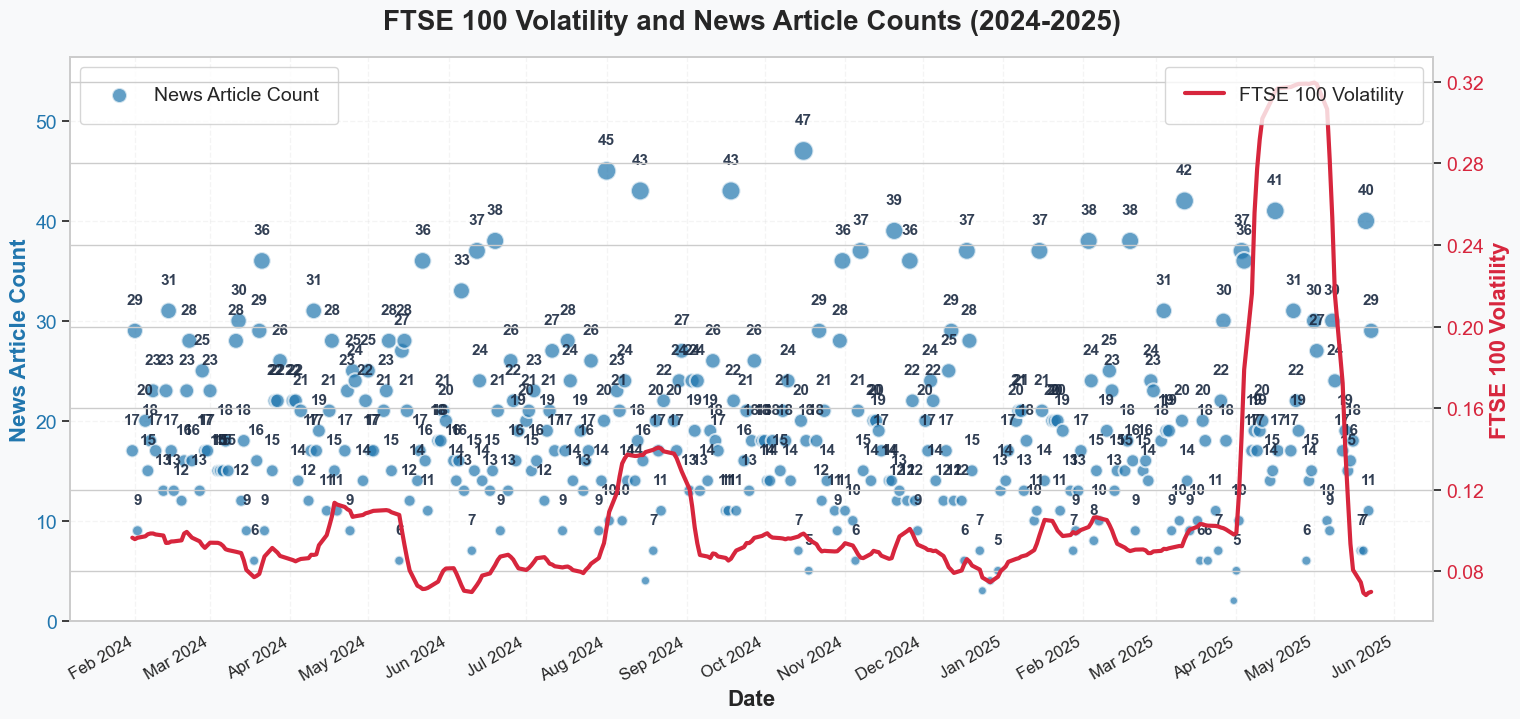

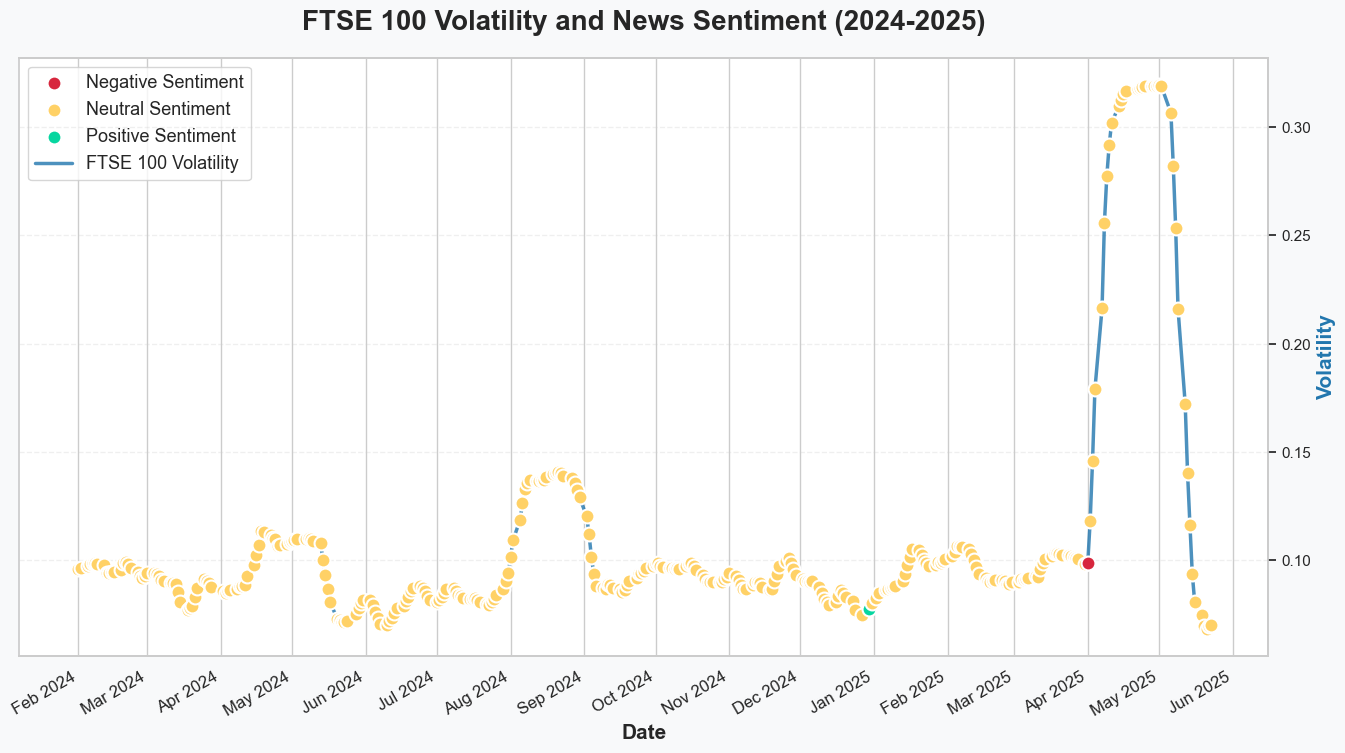

Splitting data at 2024-10-01...
Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Epoch 1/50, Train Loss: 0.11167, Val Loss: 0.10761
Epoch 10/50, Train Loss: 0.02906, Val Loss: 0.06284
Epoch 20/50, Train Loss: 0.01797, Val Loss: 0.02598
Epoch 30/50, Train Loss: 0.01598, Val Loss: 0.01573
Epoch 40/50, Train Loss: 0.01212, Val Loss: 0.01372
Epoch 50/50, Train Loss: 0.01116, Val Loss: 0.00565
Evaluating enhanced LSTM model...
Model Performance Metrics:
MSE: 0.003701
RMSE: 0.060839
MAE: 0.028196
R² Score: 0.309346


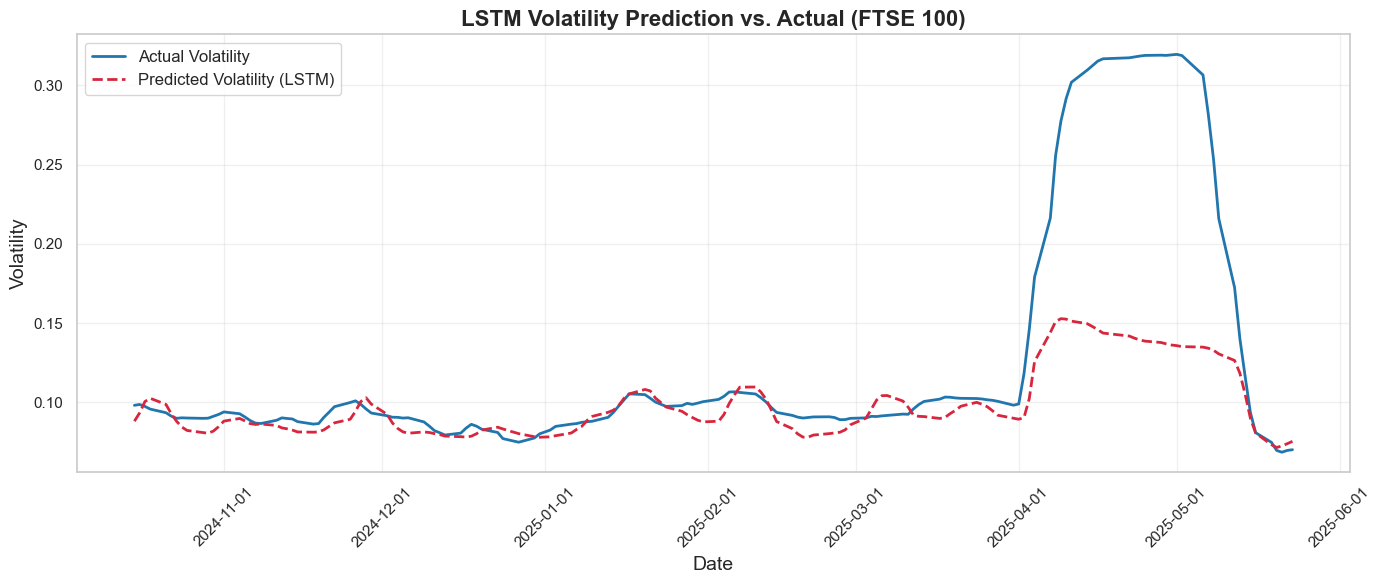

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ftse100_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    verbose=True
)

In [8]:
# Display model metrics
metrics = results['metrics']
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.6f}")

MSE: 0.003701
RMSE: 0.060839
MAE: 0.028196
R2: 0.309346


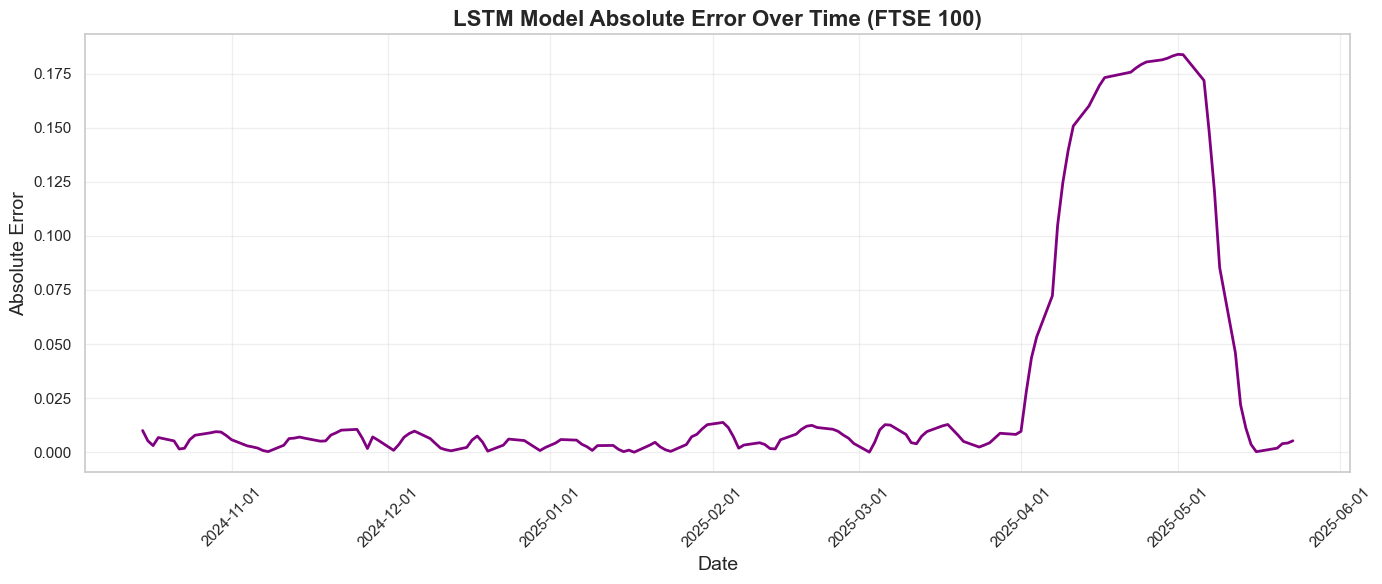

In [9]:
error = np.abs(results['y_actual'] - results['y_pred'])
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], error, color='purple', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (FTSE 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Skipping sentiment calculation (use_sentiment=False)...
Final feature columns for model: ['Volatility_Smooth', 'RSI', 'MA_Ratio', 'Volume_Ratio']


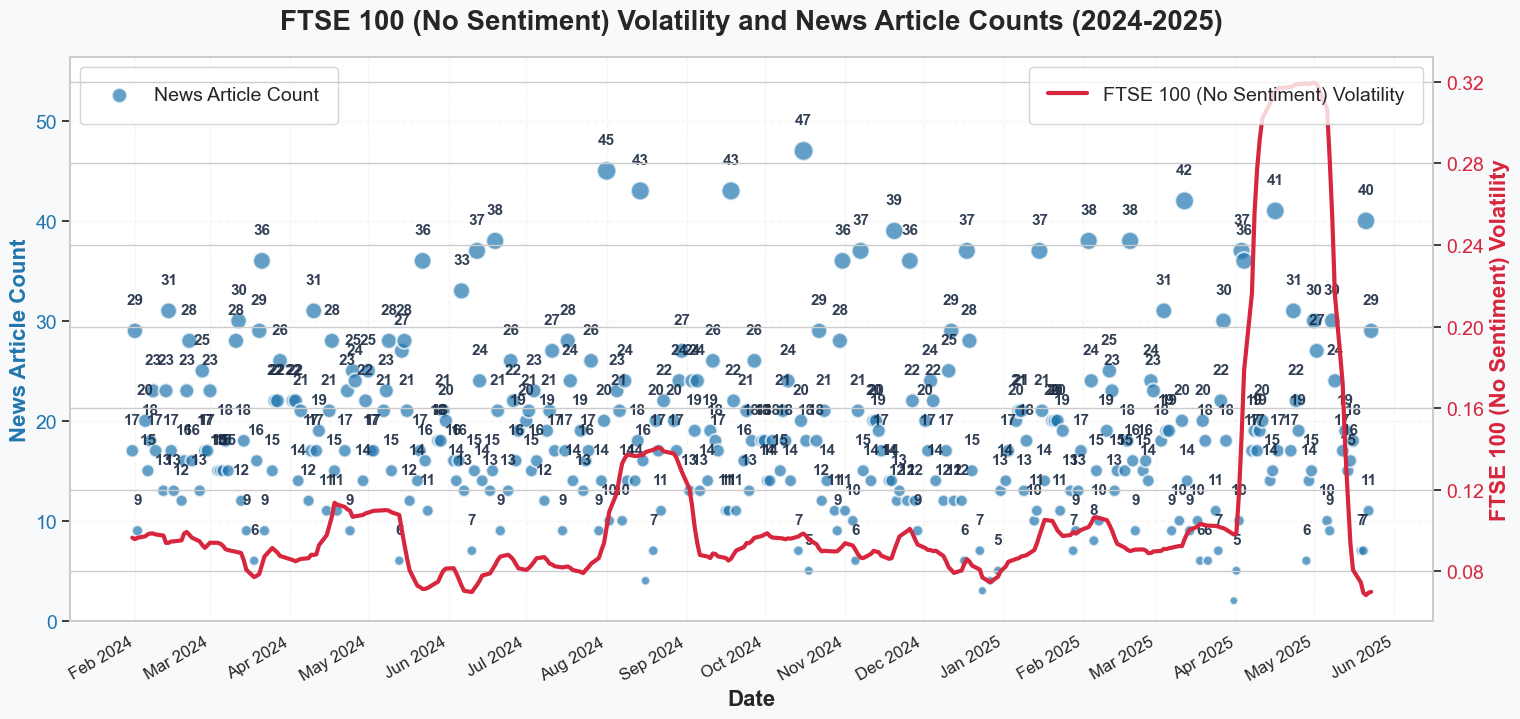

Splitting data at 2024-10-01...
Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Epoch 1/50, Train Loss: 0.13863, Val Loss: 0.11919
Epoch 10/50, Train Loss: 0.04433, Val Loss: 0.08295
Epoch 20/50, Train Loss: 0.02659, Val Loss: 0.03430
Epoch 30/50, Train Loss: 0.01872, Val Loss: 0.01383
Epoch 40/50, Train Loss: 0.01665, Val Loss: 0.00914
Epoch 50/50, Train Loss: 0.01276, Val Loss: 0.00809
Evaluating enhanced LSTM model...
Model Performance Metrics:
MSE: 0.003467
RMSE: 0.058885
MAE: 0.026800
R² Score: 0.353004


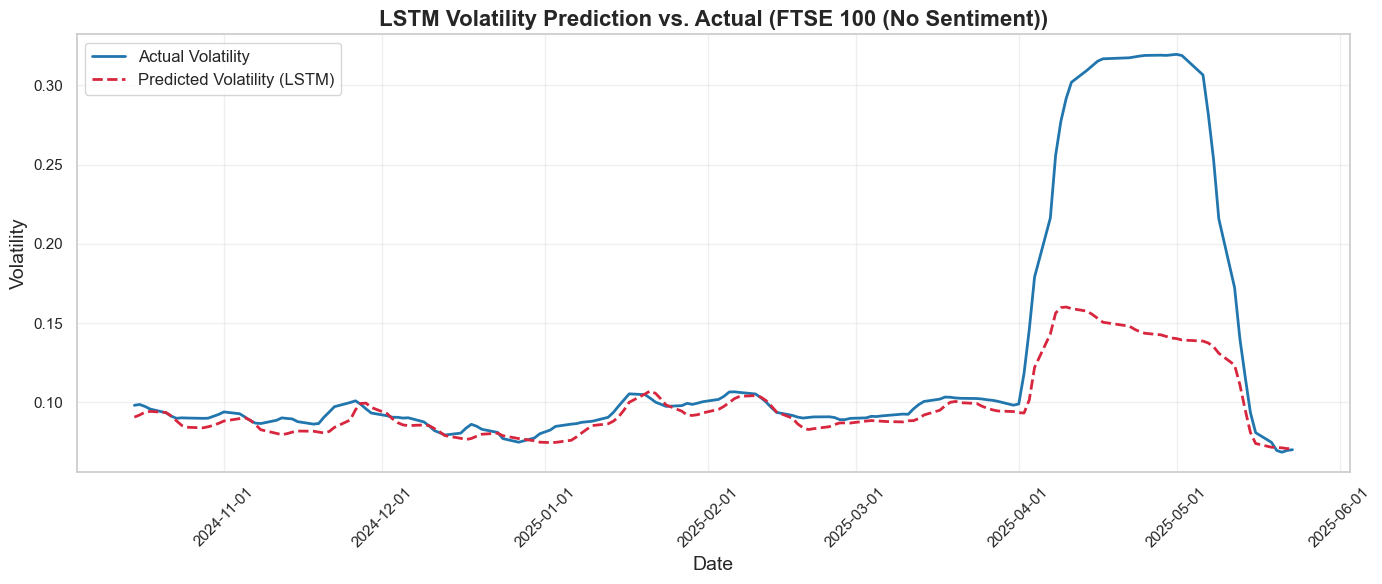

In [10]:
# Example: Run volatility analysis WITHOUT sentiment inference
# This uses only previous volatility data for predictions
results_no_sentiment = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ftse100_data,
    market_name=MARKET_NAME + " (No Sentiment)",
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    use_sentiment=False,  # NEW PARAMETER: Skip sentiment inference
    verbose=True
)

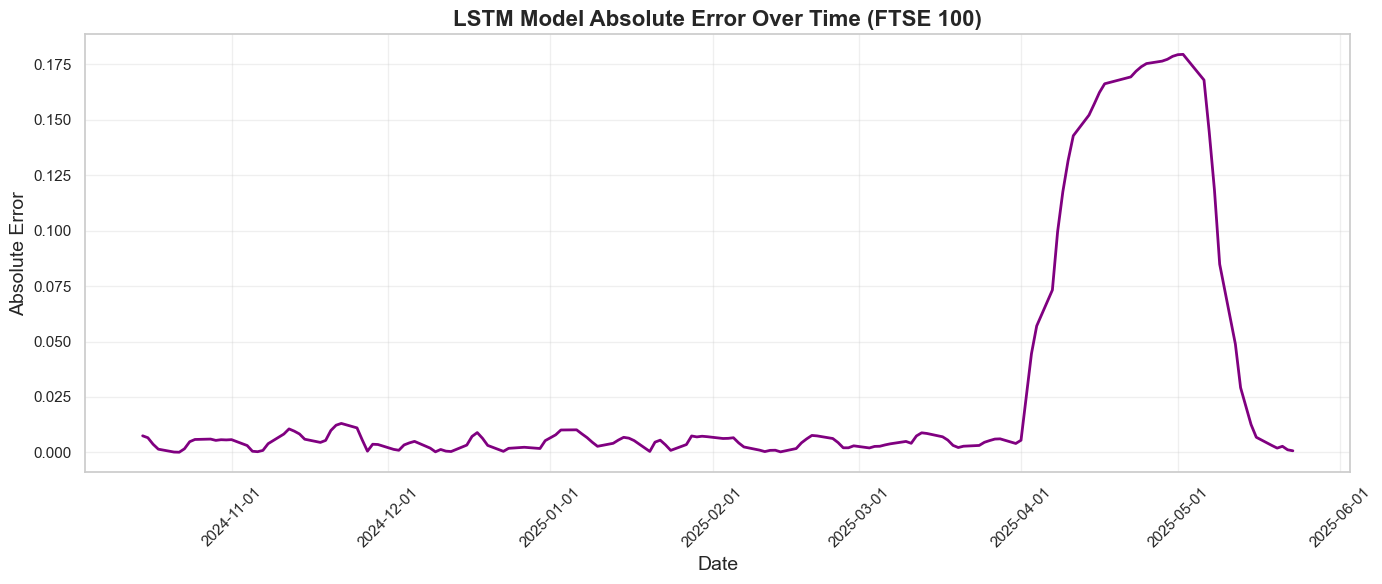

In [11]:
error = np.abs(results_no_sentiment['y_actual'] - results_no_sentiment['y_pred'])
plt.figure(figsize=(14, 6))
plt.plot(results_no_sentiment['test_dates'], error, color='purple', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (FTSE 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../news/ftse100_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

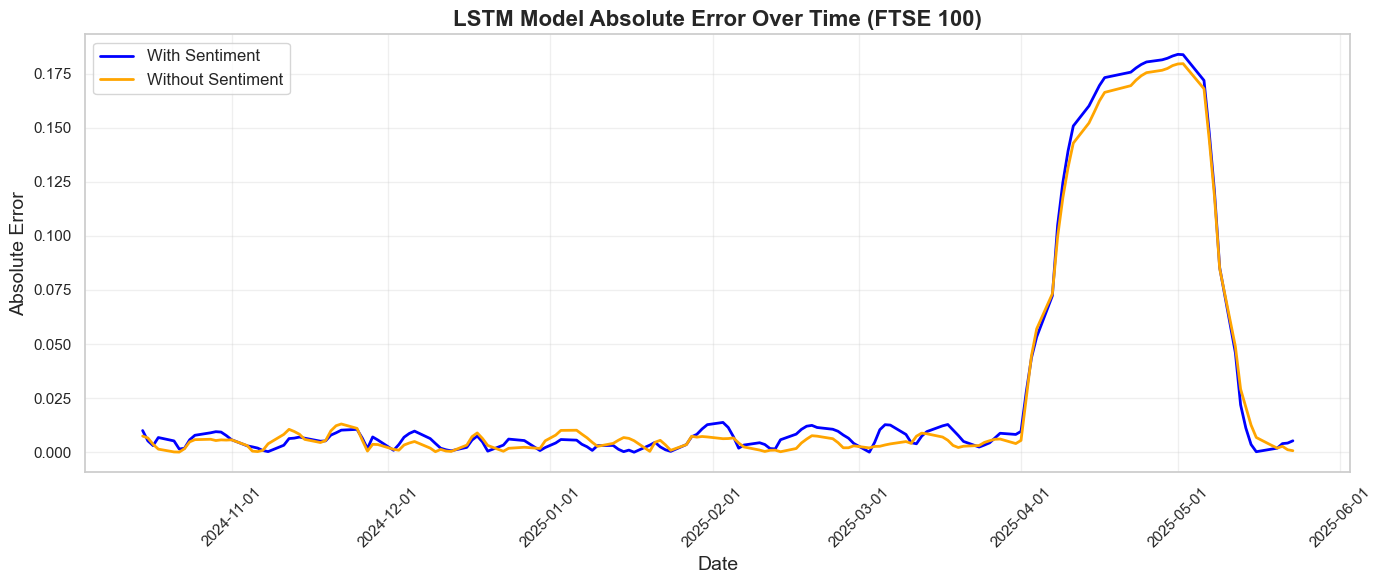

In [12]:
# Plot the MAE over time for both models
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], np.abs(results['y_actual'] - results['y_pred']), label='With Sentiment', color='blue', linewidth=2)
plt.plot(results_no_sentiment['test_dates'], np.abs(results_no_sentiment['y_actual'] - results_no_sentiment['y_pred']), label='Without Sentiment', color='orange', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (FTSE 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Compare metrics between sentiment-based and volatility-only models
print("\n=== MODEL COMPARISON ===")
print("With Sentiment:")
for metric_name, value in results['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")

print("\nWithout Sentiment (Volatility-only):")
for metric_name, value in results_no_sentiment['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")


=== MODEL COMPARISON ===
With Sentiment:
  MSE: 0.003701
  RMSE: 0.060839
  MAE: 0.028196
  R2: 0.309346

Without Sentiment (Volatility-only):
  MSE: 0.003467
  RMSE: 0.058885
  MAE: 0.026800
  R2: 0.353004
